ZeitSci: An Analysis of Recent Trends in the Natural Sciences
====

Tariq A. Hassan
----

***

Funding Simulation 
----
The animation-like graphic showing the movement of science grants around the world was made possible by the *amazing* JavaScript library for Data Visualization known as [D3.js](https://d3js.org). What follows are some brief technical notes on this process.

**Point Scaling**

$Let \hspace{2px} c$ be some scalar and $G$ be a set of research grants in some currency.

Now, $Let$

$$ p(x)= \frac {L}{1+\mathrm{e} ^{-k(x \cdot \phi^{-1} \hspace{2pt} -\hspace{2pt}x_{0})}} - \frac{L}{2} + m$$

$where$:
- $x_{0} = 0$
- $\phi = c \cdot {10}^{{\left \lfloor{\log_{10}{\max{G}}}\right \rfloor} \hspace{2pt}-\hspace{2pt}1}$
- $m = \min{G}$
- $L = \hspace{2pt} \max{G}\cdot\phi^{-1}$




This is, essentially, the logistic equation with four properties of note:

1. $x_{0} = 0$ sets the x-value of the function's midpoint equal to zero.
2. $\phi$ keeps the value of $p(x)$ close to zero, even for large values of $\max D$.
3. $m$ sets a floor for the lowest value that can be returned (notice that all other terms vanish if $x = 0$).
4. $\frac{L}{2}$ sets the y-value of the function's midpoint equal to zero. 

Additionally:<br>
- $k$ controls the *steepness* of the function.
- $c$ adds additional control over the distance of the values from zero. Specifically, larger values of $c$ reduce the distance of values returned by $p(x)$ from zero.

Let's quickly look at this as code.

In [1]:
#Imports
import math
import numpy
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

While this procedure is written in JavaScript for use by D3.js during the simulation, an implementation in python is shown below for simplicity.<br> 
Note: `c` and `k` have be set to the values they are in the simulation. 

In [4]:
def logistic_algo(x, max_value, min_value=1.5, c=2.9, k=0.9):
    """
    Algorithm for scaling a given point's radius according to a Logistic Function.
    """
    phi = c * (10**(int(math.log10(max_value)) - 1))

    L = max_value/phi
    denominator = 1 + math.e**(-1 * k * (x/phi))

    return L/denominator - L/2 + min_value

If we graph this function, we can see its action on $x$ is rather pedestrian.

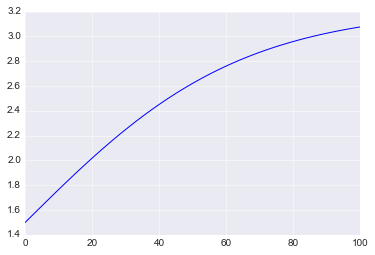

In [5]:
x = numpy.linspace(0, 100, 100) 
y = logistic_algo(x, max(x))

# compose the plot
plt.plot(x, y) 

This is *nearly* linear, but with some slight scaling to reduce the real estate of larger grants.